In [129]:
import numpy as np
import string
import os
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords
import pandas as pd

In [130]:
reviews = "reviews.csv"
data_set = pd.read_csv(reviews)
data_set2 = pd.DataFrame(data_set, columns=['buisness_name','text']) 
data_set.head()




,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


In [131]:
Text = data_set['text']
buisness_name = data_set['business_name']

preprossed_text = []
stop_words = set(stopwords.words('english'))
st = ISRIStemmer()

for text in Text:
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.split()
    text = [st.stem(word) for word in text if not word in stop_words]
    text = ' '.join(text)
    preprossed_text.append(text)


data = pd.DataFrame({'business_name':buisness_name,'text':preprossed_text})
data.head()


,business_name,text
0,Haci'nin Yeri - Yigit Lokantasi,We went Marmaris wife holiday We chose restaur...
1,Haci'nin Yeri - Yigit Lokantasi,During holiday Marmaris ate fit food Its reall...
2,Haci'nin Yeri - Yigit Lokantasi,Prices affordable The menu photo cost 108 lira...
3,Haci'nin Yeri - Yigit Lokantasi,Turkeys cheapest artisan restaurant food delic...
4,Haci'nin Yeri - Yigit Lokantasi,I dont know look terms price performance point...


In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [133]:
vectorizer = TfidfVectorizer()
vectorized_data = vectorizer.fit_transform(preprossed_text)


query = "good food and service"
processed_query = query.translate(str.maketrans('', '', string.punctuation))
processed_query = processed_query.split()
processed_query = [st.stem(word) for word in processed_query if not word in stop_words]
processed_query = ' '.join(processed_query)

query_vector = vectorizer.transform([processed_query])


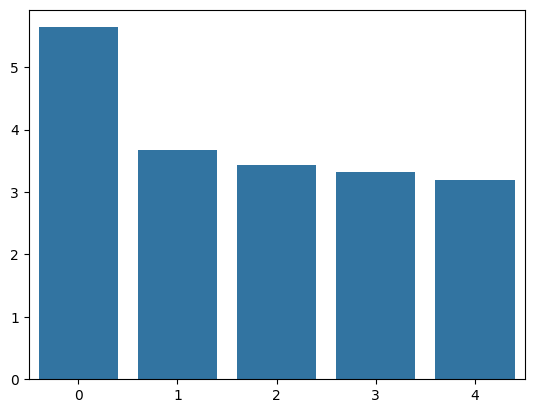

In [134]:
import seaborn as sns
lsa = TruncatedSVD(n_components=5)
lsa.fit(vectorized_data)
lsa_data = lsa.transform(vectorized_data)

lsa_query = lsa.transform(query_vector)
sigma=lsa.singular_values_
sns.barplot(x=list(range(len(sigma))), y=sigma)

similarity = cosine_similarity(lsa_data,lsa_query)


In [135]:
rankings = np.argsort(similarity,axis=0)[::-1]
rankings = rankings.flatten()

output = []
scores = []
buisness_name_sorted = []
ratings_sorted = []
Query = []
origina_review_category = []

for rank in rankings:
    output.append(data_set['text'][rank])
    scores.append(similarity[rank][0])
    buisness_name_sorted.append(data_set['business_name'][rank])
    ratings_sorted.append(data_set['rating'][rank])
    Query.append(query)
    origina_review_category.append(data_set['rating_category'][rank])



print("Top 5 reviews for the query are:")
for i in range(5):
    print(output[i])
    print("Similarity Score: ", scores[i])
    print("\n")

Top 5 reviews for the query are:
The waiters are generally very sullen and unhappy. Service is very slow. Nothing extra comes to the table. Even the starter appetizer; which is available in many kebab shops; does not come. Lahmacun was very dry and tasteless.
Similarity Score:  0.9895169110003201


They are very fast and the food tastes good too.
Similarity Score:  0.9838323607692995


They have very good soups and appetizers; including Beyran. Everything was fantastic. Oh my god Gaziantep!
Similarity Score:  0.9807519633346229


Everything was very good; the waffles were very tasty; the employees were very concerned and smiling. It is recommended.
Similarity Score:  0.9803399431212905


Pretty good sushi; attentive; friendly service..
Similarity Score:  0.9731611595723388




In [136]:
final_data = pd.DataFrame({'buisness_name':buisness_name_sorted,'text':output,'score':scores,'rating':ratings_sorted ,'Query':Query ,'original_review_category':origina_review_category})
final_data.head()

,buisness_name,text,score,rating,Query,original_review_category
0,Ciya Sofrasi,The waiters are generally very sullen and unha...,0.989517,2,good food and service,menu
1,Mcdonalds Fethiye,They are very fast and the food tastes good too.,0.983832,5,good food and service,taste
2,Yesemek,They have very good soups and appetizers; incl...,0.980752,5,good food and service,indoor_atmosphere
3,Nesh,Everything was very good; the waffles were ver...,0.980340,5,good food and service,menu
4,Sushico,Pretty good sushi; attentive; friendly service..,0.973161,5,good food and service,outdoor_atmosphere


In [137]:
words_topic_matrix = pd.DataFrame(lsa.components_,index=['topic1','topic2','topic3','topic4','topic5'],columns=vectorizer.get_feature_names_out())

#classifying most relevent words for each topic
top_words = []
for i in range(5):

    top_words.append(words_topic_matrix.loc['topic'+str(i+1)].sort_values(ascending=False)[0:10])

# Function to concatenate words of each topic
def concatenate_words(topics):
    concatenated_strings = []
    for topic in topics:
        concatenated_strings.append(' '.join(topic.index))
    return concatenated_strings

# Generate the concatenated strings
concatenated_strings = concatenate_words(top_words)

# Print the results
for i, string in enumerate(concatenated_strings):
    print(f"Topic {i+1}: {string}")




Topic 1: the good delicious place nice food service prices taste it
Topic 2: great ambiance service recommend thank thanks dishes everything food delicious
Topic 3: delicious food reasonable recommend friendly fast staff fresh prices quite
Topic 4: expensive place nice ambiance it beautiful crowded clean view its
Topic 5: prices recommend expensive high reasonable little bit amazing nice flavors


In [138]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Initialize the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Encode the input text
input_text = "conclude the topic out of this text",concatenated_strings[0]
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Generate text
output = model.generate(input_ids, max_length=10, temperature=0.7, num_return_sequences=1)

# Decode the output
output_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(output_text)

c:\Users\mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The U.S. Department of Justice
